In [ ]:
# importing required libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
pd.options.mode.chained_assignment = None 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# importing the test and training dataset from drive
train_link = 'https://drive.google.com/open?id=1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew'
test_link = 'https://drive.google.com/open?id=17H0OUGoC3-Ld-qITR8QWDIICipS8I9al'

In [ ]:
# extracting the file ids from the url
fluff, train_id = train_link.split('=')
fluff, test_id = test_link.split('=')

In [ ]:
# validating whether the entire extraction was perfect
print(train_id)
print(test_id)

1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew
17H0OUGoC3-Ld-qITR8QWDIICipS8I9al


In [ ]:
#loading the training dataset
downloaded_train = drive.CreateFile({'id':train_id}) 
downloaded_train.GetContentFile('Training.csv')  
training_df = pd.read_csv('Training.csv')

#loading the test dataset
downloaded_test = drive.CreateFile({'id':test_id}) 
downloaded_test.GetContentFile('Test.csv')
test_df = pd.read_csv('Test.csv')

In [ ]:
# quickly looking into the training dataset 
training_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04


In [ ]:
# quickly looking into the test dataset 
test_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,24520,2020-02-17
1,A,DO,8820,2020-02-20
2,A,DO,129760,2020-02-25
3,A,DO,185185,2020-02-26
4,A,DO,136382,2020-02-27


In [ ]:
# Getting the count of transactions per vendor-enterprise pair
df2 = training_df.groupby(['vendor_name', 'enterprise_name']).count()

In [ ]:
# printing the same
df2

total_amount  repayment_date
vendor_name enterprise_name                              
A           DO                         99              99
            LP                         11              11
AA          FQ                         26              26
            IF                         14              14
            IG                         55              55
...                                   ...             ...
YR          KS                         11              11
            KV                         30              30
            UD                         10              10
            YR                         14              14
Z           FP                         83              83

[243 rows x 2 columns]

In [ ]:
# Extracting the data for first enterprise vendor pair to analyse it.
sampled_df_1 = training_df.loc[(training_df['vendor_name'] == 'A') & (training_df['enterprise_name'] == 'DO')]

In [ ]:
#printing the same
sampled_df_1

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04
...,...,...,...,...
94,A,DO,23840,2020-02-11
95,A,DO,24718,2020-02-13
96,A,DO,123196,2020-03-11
97,A,DO,88260,2020-03-20


In [ ]:
#printing the datatypes of all the columns in pandas dataframe
print(sampled_df_1.dtypes)

vendor_name        object
enterprise_name    object
total_amount        int64
repayment_date     object
dtype: object


In [ ]:
# Converting the datatype of repayment_date to datetime 
sampled_df_1.loc[:, 'repayment_date'] = pd.to_datetime(sampled_df_1['repayment_date'].str.strip(), format='%Y-%m-%d')
print ('\n Parsed Data:')
print (sampled_df_1.head())


 Parsed Data:
  vendor_name enterprise_name  total_amount repayment_date
0           A              DO         38314     2019-03-11
1           A              DO        406447     2019-03-19
2           A              DO         47904     2019-03-20
3           A              DO         37547     2019-03-26
4           A              DO        186274     2019-04-04


In [ ]:
# Printing the datatypes to verify whether datatype for repayment date is changed or not
print(sampled_df_1.dtypes)

vendor_name                object
enterprise_name            object
total_amount                int64
repayment_date     datetime64[ns]
dtype: object


In [ ]:
# droppping the vendor_name and enterprise column as they are no longer needed
sampled_df_1.drop(['vendor_name', 'enterprise_name'], axis = 1, inplace = True) 

In [ ]:
# convert the daywise data to weekly data and indexing the dataframe with repayment date
sampled_df_1.set_index('repayment_date', inplace=True)
sampled_df_daily = sampled_df_1.resample('D').sum().fillna(0)
sampled_df_1 = sampled_df_1.resample('W').sum().fillna(0)

In [ ]:
# verifying whether index is set or not
sampled_df_1.index

DatetimeIndex(['2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07',
               '2019-04-14', '2019-04-21', '2019-04-28', '2019-05-05',
               '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02',
               '2019-06-09', '2019-06-16', '2019-06-23', '2019-06-30',
               '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28',
               '2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25',
               '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20',
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29', '2020-01-05', '2020-01-12',
               '2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29'],
              dtype

In [ ]:
# looking into the newly created dataframe
sampled_df_1.head()

,total_amount
repayment_date,
2019-03-17,38314
2019-03-24,454351
2019-03-31,37547
2019-04-07,229361
2019-04-14,0


In [ ]:
# Converting the dataframe into series with repayment date as indexes
ts = sampled_df_1['total_amount'] 
ts.head(10)

repayment_date
2019-03-17     38314
2019-03-24    454351
2019-03-31     37547
2019-04-07    229361
2019-04-14         0
2019-04-21     22005
2019-04-28    401079
2019-05-05     81112
2019-05-12    108412
2019-05-19     14243
Freq: W-SUN, Name: total_amount, dtype: int64

In [ ]:
# function to test the stationarity of time series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Notes: 

*   Interval of 4 is choosen for determining the rolling mean or standard deviation because data is choosen weekwise and thus, rolling mean or standard deviation is calculated per month wise.

*   Here autolag = 'AIC' is choosen in which number of lags is chosen to minimize the corresponding information criterion.




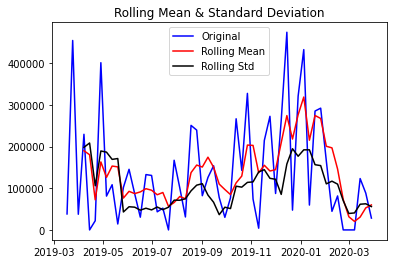

Results of Dickey-Fuller Test:
Test Statistic                 -2.617178
p-value                         0.089499
#Lags Used                      2.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [ ]:
# Testing the stattionarity of our timeseries
test_stationarity(ts)

If p > .10 → “not significant”

If p ≤ .10 → “marginally significant”

If p ≤ .05 → “significant”

If p ≤ .01 → “highly significant.

Test Statistics> critical values i. e. we do not reject the null hypothesis. And the time series is not stationary

It means our timeseries has trend and seasionality.

Lower values of P are preferred


In [ ]:
# adding this fraction to remove didvide by zero while doing log transformation
ts= ts+0.000000000000001

In [ ]:
ts

repayment_date
2019-03-17    3.831400e+04
2019-03-24    4.543510e+05
2019-03-31    3.754700e+04
2019-04-07    2.293610e+05
2019-04-14    1.000000e-15
2019-04-21    2.200500e+04
2019-04-28    4.010790e+05
2019-05-05    8.111200e+04
2019-05-12    1.084120e+05
2019-05-19    1.424300e+04
2019-05-26    1.019930e+05
2019-06-02    1.453660e+05
2019-06-09    8.683200e+04
2019-06-16    3.053900e+04
2019-06-23    1.327260e+05
2019-06-30    1.306530e+05
2019-07-07    4.342600e+04
2019-07-14    5.219600e+04
2019-07-21    1.000000e-15
2019-07-28    1.670630e+05
2019-08-04    1.009530e+05
2019-08-11    3.106900e+04
2019-08-18    2.506890e+05
2019-08-25    2.394220e+05
2019-09-01    8.203300e+04
2019-09-08    1.258420e+05
2019-09-15    1.538520e+05
2019-09-22    7.755500e+04
2019-09-29    3.018400e+04
2019-10-06    7.719200e+04
2019-10-13    2.665640e+05
2019-10-20    1.427910e+05
2019-10-27    3.274660e+05
2019-11-03    7.402200e+04
2019-11-10    4.098000e+03
2019-11-17    2.145290e+05
2019-11-24   

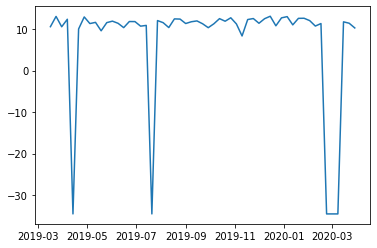

In [ ]:
#applying log transformation to reduce the trend by penalizing higher values
ts_log = np.log(ts)
plt.plot(ts_log)

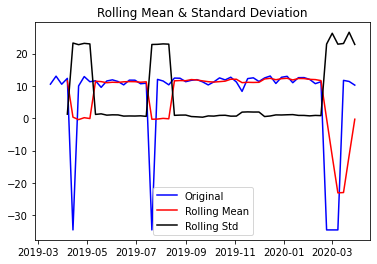

Results of Dickey-Fuller Test:
Test Statistic                 -5.051192
p-value                         0.000018
#Lags Used                      0.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [ ]:
test_stationarity(ts_log)

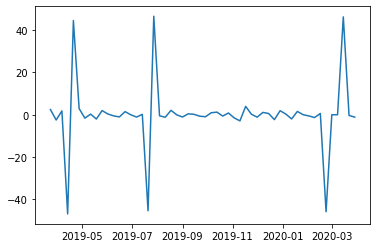

In [ ]:
# using first order differencing to eliminate trend and seasionality or to improve stationarity
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

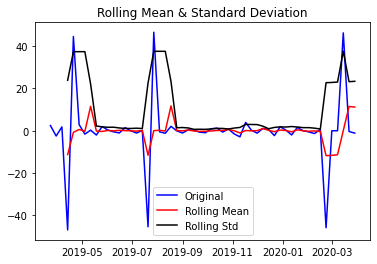

Results of Dickey-Fuller Test:
Test Statistic                 -4.789428
p-value                         0.000057
#Lags Used                      4.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


In [ ]:
# applying Dickey Fuller Test to check for stationarity
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

ARIMA model
*   P(auto regressive lags)
*   d(order of differentiation)
*   Q(moving avg.)

The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.


In [ ]:
#ACF and PACF plots:
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

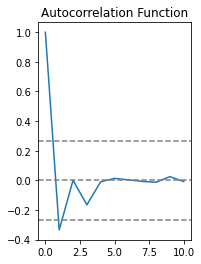

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

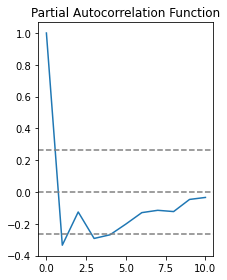

In [ ]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 11321.7306')

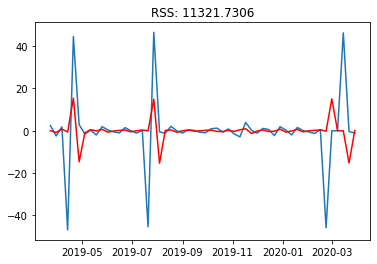

In [ ]:
#AR Model
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 10201.4971')

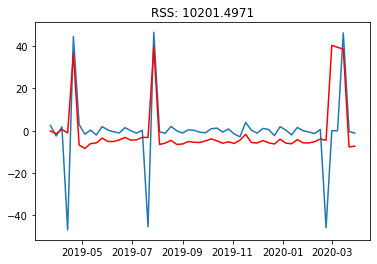

In [ ]:
#MA model
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 9122.9615')

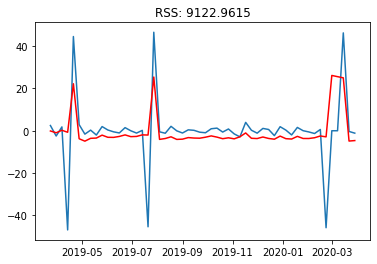

In [ ]:
#Combined Model
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [ ]:
# storing and printing the results
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

repayment_date
2019-03-24    -0.110220
2019-03-31    -0.953594
2019-04-07     0.223472
2019-04-14    -0.716844
2019-04-21    22.208484
Freq: W-SUN, dtype: float64


In [ ]:
# finding the cumulative sum to add it to base number to convert the series back to the original ts_log
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())


repayment_date
2019-03-24    -0.110220
2019-03-31    -1.063814
2019-04-07    -0.840342
2019-04-14    -1.557186
2019-04-21    20.651298
Freq: W-SUN, dtype: float64


In [ ]:
# taking the base series and adding the cumulative sum to extract the original series not a time lagged series
predictions_ARIMA_log = pd.Series(ts_log, index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

repayment_date
2019-03-17    10.553571
2019-03-24    12.916405
2019-03-31     9.469535
2019-04-07    11.502711
2019-04-14   -36.095962
Freq: W-SUN, dtype: float64

Text(0.5, 1.0, 'RMSE: 2989167814075.2871')

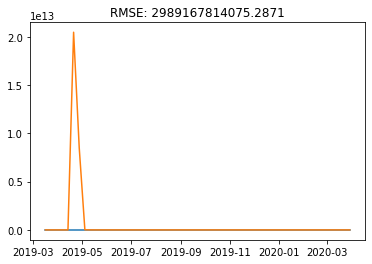

In [ ]:
#Converting the logs to original values
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
#predicted values
predictions_ARIMA

repayment_date
2019-03-17    3.831400e+04
2019-03-24    4.069337e+05
2019-03-31    1.295886e+04
2019-04-07    9.898373e+04
2019-04-14    2.107283e-16
2019-04-21    2.047700e+13
2019-04-28    8.492604e+12
2019-05-05    1.252119e+10
2019-05-12    4.651619e+08
2019-05-19    1.921859e+06
2019-05-26    1.724705e+06
2019-06-02    1.108592e+05
2019-06-09    2.872239e+03
2019-06-16    6.878329e+01
2019-06-23    4.179087e+01
2019-06-30    2.539571e+00
2019-07-07    5.762324e-02
2019-07-14    9.859274e-03
2019-07-21    2.481723e-23
2019-07-28    4.372212e+08
2019-08-04    4.425898e+06
2019-08-11    3.470836e+04
2019-08-18    1.596982e+04
2019-08-25    2.543380e+02
2019-09-01    1.637736e+00
2019-09-08    9.884300e-02
2019-09-15    3.830703e-03
2019-09-22    5.690108e-05
2019-09-29    1.047241e-06
2019-10-06    2.340972e-07
2019-10-13    3.970600e-08
2019-10-20    4.941964e-10
2019-10-27    4.050286e-11
2019-11-03    2.000962e-13
2019-11-10    6.358711e-16
2019-11-17    1.175253e-14
2019-11-24   

In [ ]:
predictions_ARIMA.shape

(55,)

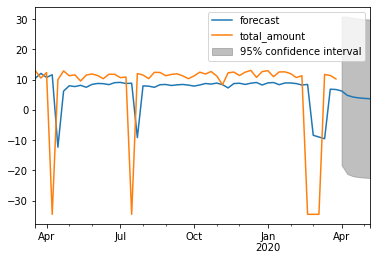

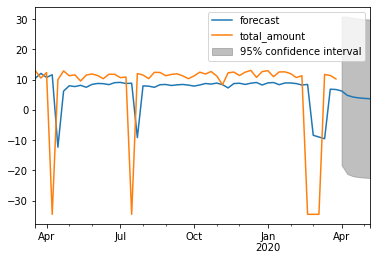

In [ ]:
# Plot with forecasted values
results_ARIMA.plot_predict(1,60)

In [ ]:
#Forecasting for next five steps
x = results_ARIMA.forecast(steps = 5)

Output value x description
1.   Forecastndarray : Array of out of sample forecasts
2.   stderrndarray : Array of the standard error of the forecasts.
3.   conf_intndarray : 2d array of the confidence interval for the **forecast*

In [ ]:
x

(array([6.27783014, 4.82684836, 4.25131688, 3.97961056, 3.81334681]),
 array([12.53788995, 13.27148435, 13.35712299, 13.36740063, 13.36863799]),
 array([[-18.29598262,  30.85164289],
        [-21.18478298,  30.8384797 ],
        [-21.92816312,  30.43079688],
        [-22.22001325,  30.17923437],
        [-22.38870216,  30.01539579]]))

In [ ]:
x[0]

array([6.27783014, 4.82684836, 4.25131688, 3.97961056, 3.81334681])

In [ ]:
# storing and printing the results
x_cumsum = x[0].cumsum()
x_cumsum

array([ 6.27783014, 11.1046785 , 15.35599538, 19.33560594, 23.14895276])

In [ ]:
forecasted_log = np.add(x[0],x_cumsum)

In [ ]:
predictions_ARIMA = np.exp(forecasted_log)

In [ ]:
predictions_ARIMA

array([2.83696496e+05, 8.29801473e+06, 3.27602736e+08, 1.33557990e+10,
       5.12363191e+11])

In [ ]:
sampled_df_test = test_df.loc[(test_df['vendor_name'] == 'A') & (test_df['enterprise_name'] == 'DO')]

In [ ]:
#Checking the test set
sampled_df_test

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,24520,2020-02-17
1,A,DO,8820,2020-02-20
2,A,DO,129760,2020-02-25
3,A,DO,185185,2020-02-26
4,A,DO,136382,2020-02-27
5,A,DO,18221,2020-03-03
6,A,DO,102873,2020-03-04


This dataset is overlapping with the training set.
So lets discard this and consider only the training set and do the predictions for next two weeks after the training set

In [ ]:
#Weekly predictions
predictions_ARIMA[1:3]

array([8.29801473e+06, 3.27602736e+08])

In [ ]:
# creating a datafrmae with next two weeks dates
from datetime import datetime, timedelta
df = pd.DataFrame(pd.date_range('2020-04-05', periods= 14,  freq='D'), columns=['repayment_date'])

In [ ]:
df.set_index('repayment_date', inplace = True)

In [ ]:
df

""
repayment_date
2020-04-05
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-10
2020-04-11
2020-04-12
2020-04-13


In [ ]:
sampled_df_daily['daily_ratio'] = sampled_df_daily['total_amount']/sum(sampled_df_daily['total_amount'])

In [ ]:
sampled_df_daily['day_of_week'] = sampled_df_daily.index.dayofweek

In [ ]:
ratios_daywise = pd.Series(sampled_df_daily['daily_ratio'].groupby(sampled_df_daily['day_of_week']).sum())

In [ ]:
ratios_daywise

day_of_week
0    0.177922
1    0.278617
2    0.188617
3    0.190961
4    0.160441
5    0.003442
6    0.000000
Name: daily_ratio, dtype: float64

In [ ]:
daywiseamount = []
for i in range(predictions_ARIMA[1:3].size):
  for j in range(0,7):
    daywiseamount.append(predictions_ARIMA[i:i+1][0]*ratios_daywise[j])

In [ ]:
df['total_amount'] = daywiseamount

In [ ]:
df

,total_amount
repayment_date,
2020-04-05,5.047598e+04
2020-04-06,7.904278e+04
2020-04-07,5.350985e+04
2020-04-08,5.417493e+04
2020-04-09,4.551662e+04
2020-04-10,9.763425e+02
2020-04-11,0.000000e+00
2020-04-12,1.476403e+06
2020-04-13,2.311971e+06
